# Hadoop Log Data Anomaly Detection

The data we analyze are the logs generated from a Hadoop cluster. We are going to detect the log types by modelling. 

## Data Pre-processing

First, we process the data from the log file. We create a dataframe based on the log info. We extract the date, hour, log type, information in the bracket, and the function(which is after the .hadoop) of the log. In addition, we determine if the log contains the key word "Error" or "Exception" and store the result in two columns.  

In [95]:
import pandas as pd
import altair as alt
import re
path = "combined.log"
data = []
with open(path) as f:
    f = f.readlines()
    for line in f:
       new_line = line.split()
       if len(new_line)>3:
         if new_line[2]=="INFO" or new_line[2]=="WARN" or new_line[2]=="ERROR":
            date = new_line[0]
            hour = new_line[1]
            label = new_line[2]
            bracketsInfo= line[line.find('[')+len('['):line.find(']')]
            func = ""
            m = line.split(".hadoop.",1)
            if len(m)>1:
              func = m[1].split(".",1)[0]
            
            hasError = False
            hasException =False
            message = []
            for i in range(3,len(new_line)):
              if "Error" in new_line[i]:
                hasError = True
              if "Exception" in new_line[i]:
                hasException = True
              message.append(new_line[i])
            data.append([date,hour,label,bracketsInfo,hasError,hasException,func,message])


df = pd.DataFrame(data, columns=['date', 'hour', 'label','bracketsInfo','hasError','hasException','func','message'])


In [96]:
df.head(5)

,date,hour,label,bracketsInfo,hasError,hasException,func,message
0,2015-10-17,"15:37:56,547",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
1,2015-10-17,"15:37:56,899",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
2,2015-10-17,"15:37:56,900",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
3,2015-10-17,"15:37:57,036",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."
4,2015-10-17,"15:37:57,634",INFO,main,False,False,mapreduce,"[[main], org.apache.hadoop.mapreduce.v2.app.MR..."


In [97]:
df = df.drop(index=114484) # drop miss messagge

In [98]:
len(df)

127018

## Exploratory Data Analysis

In [99]:
df[df['hasError']==True].count()

date            49
hour            49
label           49
bracketsInfo    49
hasError        49
hasException    49
func            49
message         49
dtype: int64

In [100]:
df[df['hasException']==True].count()

date            303
hour            303
label           303
bracketsInfo    303
hasError        303
hasException    303
func            303
message         303
dtype: int64

In [101]:
df['func'].unique()

array(['mapreduce', 'yarn', 'metrics2', 'ipc', '', 'http', 'mapred',
       'hdfs', 'conf', 'service'], dtype=object)

In [102]:
df['bracketsInfo'].unique()

array(['main', 'Socket Reader #1 for port 47455', 'IPC Server Responder',
       ..., 'IPC Server handler 11 on 52529',
       'IPC Server handler 25 on 52529', 'Thread-114'], dtype=object)

In [103]:
len(df['bracketsInfo'].unique())

1809

In [104]:
pd.DataFrame(df['bracketsInfo'].unique())

,0
0,main
1,Socket Reader #1 for port 47455
2,IPC Server Responder
3,IPC Server listener on 47455
4,AsyncDispatcher event handler
...,...
1804,IPC Server handler 7 on 52529
1805,IPC Server handler 24 on 52529
1806,IPC Server handler 11 on 52529
1807,IPC Server handler 25 on 52529


1. count error and exception of func

In [105]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook 
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [106]:

df_exp = df.explode('func').explode('hasException')
df_err = df.explode('func').explode('hasError')

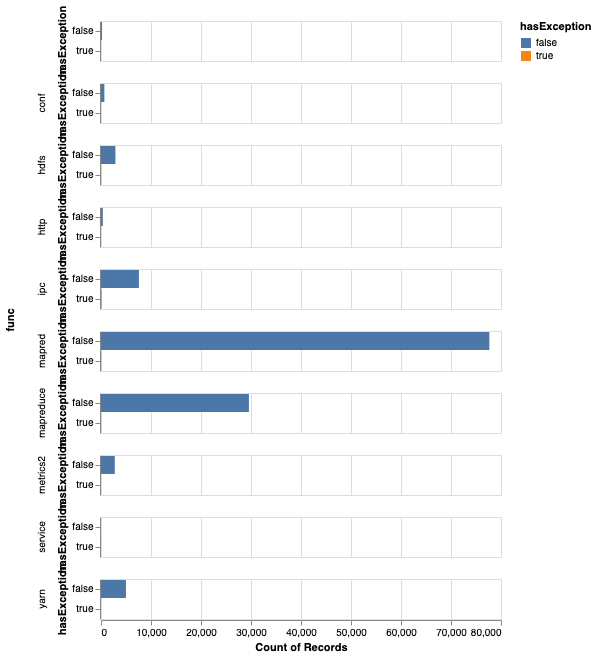

In [107]:
alt.Chart(df_exp).mark_bar().encode(
    x='count()',
y='hasException',
    color='hasException'
).facet(
    row='func'
)

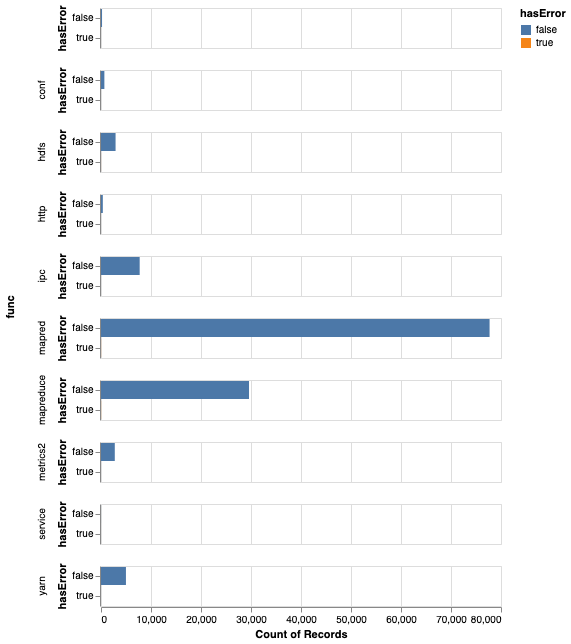

In [108]:
alt.Chart(df_err).mark_bar().encode(
    x='count()',
y='hasError',
    color='hasError'
).facet(
    row='func'
)

2. label distribution

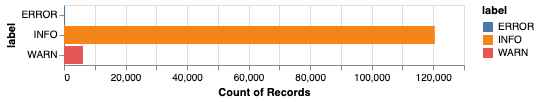

In [109]:
alt.Chart(df).mark_bar().encode(
    x='count()',
y='label',
    color='label'
)

3. error/warning label date distribuiton

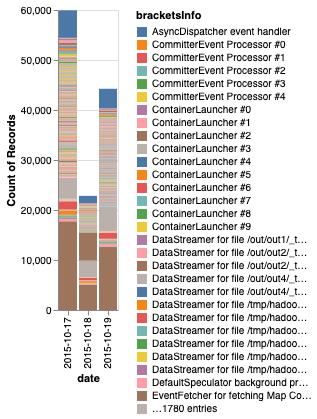

In [110]:
alt.Chart(df).mark_bar().encode(
    x='date',
y='count()',
    color='bracketsInfo'
)

## Tentative Model Choices for Anomaly Detection

The log data we analyze has a label identify the data into three groups---'INFO', 'WARN' AND 'ERROR'. We separate the the data into two parts---training set and test set. Our aim is to create a model to separate the log message into the three categories. We intend to use Logistic regression, Random Forest Classifier, Bagging, Ada-boosting and Perceptron to model the training set, and then use the test set to evaluate the accuracy of the models.

In [111]:
dict_mode = {'INFO':1,'WARN':2,'ERROR':3}
df=df.replace({"label": dict_mode})
df.label = df.label.astype('category')
df.bracketsInfo = df.bracketsInfo.astype('category')
df.func = df.func.astype('category')
df.hasError = df.hasError.astype('boolean')
df.hasException = df.hasException.astype('boolean')
df=df.drop(columns=['message','date','hour'])

In [112]:
feature_df = pd.get_dummies(df,prefix=['bracketsInfo','func','hasError','hasException'],columns=['bracketsInfo','func','hasError','hasException'])

### Logistic Regression

In [113]:
from sklearn.model_selection import train_test_split
labeld = feature_df['label']
featured = feature_df.loc[:, feature_df.columns != 'label']
x_train, x_test, y_train, y_test = train_test_split(featured,labeld,test_size=0.2)


In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix,plot_confusion_matrix

clf = LogisticRegression(max_iter=10)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
print("mse of logistic regression is: ", mse_test)

/Users/alicesong/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


mse of logistic regression is:  0.014131632813730121


In [115]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test, y_pred)
print("accuracy score is: ", acc_test)

accuracy score is:  0.9933081404503228


In [116]:
coef_df = pd.DataFrame(clf.coef_,columns=x_train.columns,
                       index=['INFO','WARN','ERROR'])
coef_df

,bracketsInfo_AsyncDispatcher event handler,bracketsInfo_CommitterEvent Processor #0,bracketsInfo_CommitterEvent Processor #1,bracketsInfo_CommitterEvent Processor #2,bracketsInfo_CommitterEvent Processor #3,bracketsInfo_CommitterEvent Processor #4,bracketsInfo_ContainerLauncher #0,bracketsInfo_ContainerLauncher #1,bracketsInfo_ContainerLauncher #2,bracketsInfo_ContainerLauncher #3,...,func_ipc,func_mapred,func_mapreduce,func_metrics2,func_service,func_yarn,hasError_False,hasError_True,hasException_False,hasException_True
INFO,0.853855,-0.140254,-0.484832,-0.314788,-0.270970,-0.112451,0.230371,0.243168,0.230745,0.087792,...,-0.744618,2.356346,0.342093,0.227170,-0.008651,0.537993,1.407915,-0.111437,1.164313,0.132164
WARN,-0.551491,0.144147,0.490042,0.318449,0.274053,0.113911,-0.199594,-0.212313,-0.200479,-0.068590,...,1.229937,-1.428408,-1.098012,-0.168298,0.009384,-0.420294,-0.367686,0.069437,-0.194372,-0.103877
ERROR,-0.302364,-0.003894,-0.005210,-0.003661,-0.003083,-0.001461,-0.030777,-0.030855,-0.030266,-0.019202,...,-0.485319,-0.927938,0.755919,-0.058873,-0.000734,-0.117698,-1.040228,0.042000,-0.969941,-0.028287


## Any Additional Techniques to Highlight

As we have known that the log data comes from the Hadoop cluster experiment, there are three types of reasons---Machine down, network disconnect, and disk full---to cause the failures. The additional techniques to highlight might be detect the logs relate to the three types of failures, but it is very difficult and needs more time.